# `trending` demo

### Overview
This demo explains a simple, lightweight approach for quantifying "recent growth."

### Motivation
Trending-ness is important for content-based companies (think: Spotify and reddit) which may want to surface up-and-coming content instead of content that simply has the highest volume. E.g., in one anaysis at Zillow, we were determining which neighborhoods were up-and-coming, and one simple and intuitive way of doing this was by finding neighborhoods that fell in the quadrant where home values were low but recent growth was high, relative to other neighborhoods in that city.

But what exactly is "recent growth"? To compute the growth between two values in the time series—say, the most recent value and the value from one week ago—is brittle in that it depends only on those points. This is a problem especially for noisy time series. Smoothing helps, but only a bit. What we really want to quantify is a shape, which involves many (or potentially all) data points.

### Approach
My preferred way of quantifying recent growth is by taking the weighted geometric mean of growth rates, where the weights are a *reversed* geometric series (to weight recent growth more heavily). That's it!

More formally, the steps are as follows:
1. Compute the growth rates between consecutive values in the series. So for a series $\mathbf{x} = \{x_1, x_2, \ldots, x_n\}$, the growth series would be $\mathbf{g}$ where $g_i = \frac{x_{i + 1}}{x_i}$. The length of $\mathbf{g}$ is $n - 1$.
1. Compute weights $\mathbf{w}$ where $w_i = r^{(n - 1) - i}$ and $0 \lt r \le 1$.
1. Compute the weighted geometric mean:
$$
{\bar  {g}}=\left(\prod _{{i=1}}^{n - 1}g_{i}^{{w_{i}}}\right)^{{1/\sum _{{i=1}}^{n - 1}w_{i}}}
$$

You could write this in fewer than ten lines of code. (Mine's more verbose for attempted clarity. Still, there are more lines of explanation here than actual code ¯\\\_(ツ)\_/¯.)

The only parameter is $r$, and it can be chosen intuitively using the process described later in this demo.

In [1]:
from math import sqrt
import random

import matplotlib.pyplot as plt

from trending import trending

%matplotlib inline

### Random walk generation
To see what the formulas above actually do, let's start by generating lots of random walks, each with $n$ observations. To have these random walks reflect data we might see in the wild (e.g., clicks or views), only positive values are allowed. Also, the random walks do not all start at zero; instead, their starting point is chosen randomly to be between $0$ and $2\sqrt{n}$. 

In [2]:
def random_walk(n):
    step_set = [-1, 0, 1]
    starting_point = random.randint(0, int(2 * sqrt(n)))
    vals = [starting_point]
    for _ in range(1, n):
        val = vals[-1] + random.choice(step_set)
        val = max(0, val)  # only positive values allowed
        vals.append(val)
    return vals


def generate_series(num_series, n):
    series = [random_walk(n) for _ in range(num_series)]
    return series


random.seed(20190805)
n = 500
num_series = 10000
series = generate_series(num_series, n)

### Plotting series with highest recent growth
Next we'll choose a few values for $r$. For each $r$, we'll compute recent growth for all random walks using the `recent_growth` function and plot the ones with the strongest recent growth.

One issue is that choosing $r$ directly is hard. How do we know if $r=0.9937$ gives us a better result than $r=0.9985$? And what does our choice of $r$ tell us about how weights are distributed across the time series?

Thankfully we can avoid having to choose $r$ directly. We'll use a function `find_r` that finds the value of $r$ such that the sum of the weights of the last $m$ observations is proportion $p$ of the sum of all weights. To reduce the number of parameters, we'll set $p=0.5$ and only vary $m$. This also gives our choice of $r$ a nice intuitive grounding.

As a pre-processing step, we'll add a pseudo count to each value in each series, which has two main benefits:
1. It avoids divide-by-zero errors. Otherwise, an increase from 0 to 1 has undefined growth.
1. It tapers growth values toward 1, but does so *disproportionally* for series with values close to zero. Otherwise, a time series of mostly 1's jumping up to 2's and 3's would be seen as having massive growth.

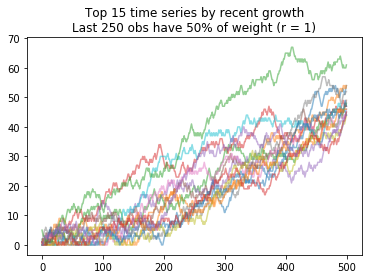

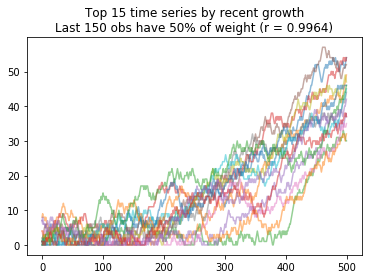

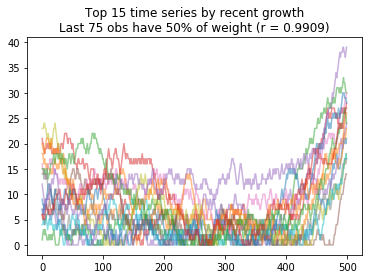

In [3]:
def plot_trending(p, m, n, series, pseudo_count=15, top_n=15, highest=True):
    """Find r and plot series with highest recent growth."""
    r = trending.find_r(p, m, n)
    def _growth_func(a):
        a = [x + pseudo_count for x in a]
        return trending.recent_growth(a, r)
    series = sorted(series, key=_growth_func, reverse=highest)

    for i in range(top_n):
        plt.plot(series[i], alpha=0.5)
    desc_word = 'Top' if highest else 'Bottom'
    title = (f'{desc_word} {top_n} time series by recent growth'
             f'\nLast {m} obs have 50% of weight (r = {r:0.4g})')
    plt.title(title)
    plt.show()


p = 0.5
m_list = [250, 150, 75]
for m in m_list:
    plot_trending(p, m, n, series)

We see that when $r = 1$, the series favors random walks that grow evenly over the entire series, starting low and ending high. This is because when $r = 1$, all observations in the series are given equal weight. In the next plot, where the last 150 observations have 50% of the weight, the series start to have more of a hockey-stick shape, favoring more recent growth. When the last 50 observations have 50% of the weight, this pattern becomes even more pronounced, with observations before 250 having only around 3% of the total weight (you can compute this with `1 - compute_weight_frac(0.9931, 500, 1000)`).

We can also show the series with the lowest (or strongest *negative*) recent growth.

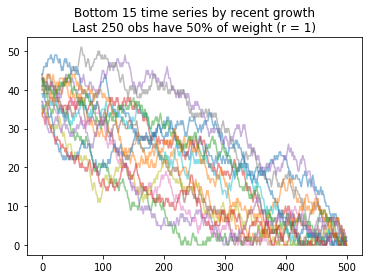

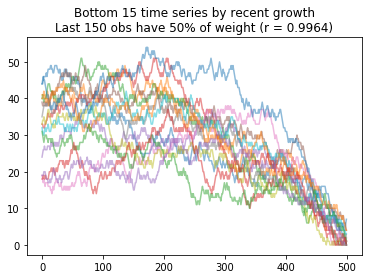

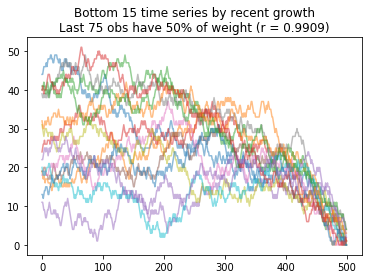

In [4]:
# Plot lowest (or strongest *negative*) recent growth.
for m in m_list:
    plot_trending(p, m, n, series, highest=False)